# 2/26/21 - This notebook extends the model fitting of G250289_2730 to 3 phases:
## Phase 1: fit lens light with small mask
## Phase 2: fit source light with annular mask
## Phase 3: fit all for lens mass

In [1]:
### libraries
%matplotlib inline
# set workspace path
from pyprojroot import here
workspace_path = str(here())#'/data/sknabel/autolens_workspace'
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import matplotlib.pyplot as plt
from autoconf import conf
import autolens as al
import autolens.plot as aplt
import autofit as af
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.stats import sigma_clip as clip
from os import path
import time

# set datetime variable
datetime = time.strftime("%d%m%Y-%H%M%S")

# paths
autoz_path = '/data/sknabel/autoz_lens_model/'
file_path = f'{autoz_path}files/'
csv_path = f'{file_path}csv/'
fits_path = f'{file_path}fits/'
png_path = f'{autoz_path}visuals/png/'
pdf_path = f'{autoz_path}visuals/pdf/'

In /soft/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /soft/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /soft/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /soft/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /soft/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_tes

/data/sknabel/autoz_lens_model
Working Directory has been set to `/data/sknabel/autoz_lens_model`


In [2]:
# this should be constant across experiments

gama_id = 250289
links_id = 2730

object_folder = f'{fits_path}G{gama_id}_{links_id}/'
output_folder = f'{autoz_path}output/G{gama_id}_{links_id}/'

In [3]:
# set up tools for tracking the experiments (log of outputs and table of time to convergence and log likelihood)

### CONTINUE LOG FROM FIRST EXPERIMENT

#Start a log.txt file
#log = open(f"{autoz_path}output/G250289_2730/experiment_log", 'a')
#log.write(f'This logs the outputs from autolens experiments on G250289_2730 on datetime {datetime}. PARTY ON WAYNE! \n')
#log.write(f'\n')
#log.close()


In [5]:
# Start a pandas dataframe
#performance_log = pd.DataFrame(columns=['Experiment', 
#                                        'phase1_time', 
#                                        'phase1_likelihood', 
#                                        'phase2_time', 
#                                        'phase2_likelihood' 
#                                        ])

# load performance log from csv
performance_log = pd.read_csv(f'{csv_path}G{gama_id}_{links_id}_performance_log.csv')
#print(performance_log)
print(performance_log)

    Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1.1  \
0            0           0.0             0.0               0.0   
1            1           1.0             0.0               NaN   
2            2           2.0             0.0               NaN   
3            3           3.0             0.0               NaN   
4            4           4.0             0.0               NaN   
5            5           5.0             0.0               NaN   
6            6           0.0             NaN               NaN   
7            7           0.0             NaN               NaN   
8            8           0.0             NaN               NaN   
9            9           0.0             NaN               NaN   
10          10           0.0             NaN               NaN   
11          11           0.0             NaN               NaN   
12          12           0.0             NaN               NaN   
13          13           0.0             NaN               NaN   
14        

### Initial Setup

INFO:numexpr.utils:Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Lens and source types: ['PG + ELG']
Lens and source redshifts at [0.40121394] and [0.71961558].
Einstein radius prior: 0.7818634676165951
Plotting r-band


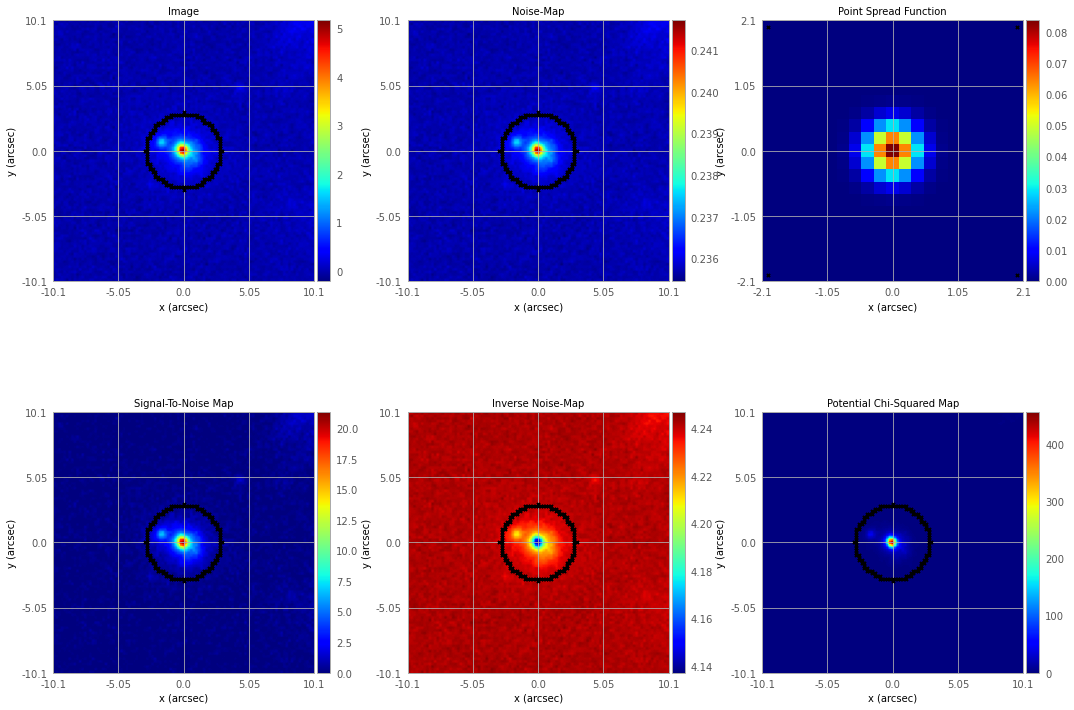

In [6]:
# load object data table
links = pd.read_csv(f'{csv_path}/latest/links_sample_latest.csv')
lens_galaxy_data = links[links.GAMA_ID == gama_id]
print(f'Lens and source types: {lens_galaxy_data.type.values}')
zlens=lens_galaxy_data.zlens.values
zsource=lens_galaxy_data.zsource.values
einstein_radius=np.mean([lens_galaxy_data.theta_e_pm.values, lens_galaxy_data.theta_e_sis.values]) # take average of einstein radius estimates for prior
print(f'Lens and source redshifts at {zlens} and {zsource}.')
print(f'Einstein radius prior: {einstein_radius}')

# load r-band imaging
imaging_r = al.Imaging.from_fits(image_path=path.join(object_folder, f'{links_id}_r_image.fits'),
                              noise_map_path=path.join(object_folder, f'{links_id}_r_noisemap.fits'),
                              psf_path=path.join(object_folder, f'{links_id}_r_psf.fits'),
                               pixel_scales=0.2)

# set up mask
mask = al.Mask2D.circular(
    shape_native=imaging_r.shape_native, pixel_scales=imaging_r.pixel_scales, sub_size=2, radius=3.0
)
visuals_2d = aplt.Visuals2D(mask=mask)

# plot subplots for first view
print('Plotting r-band')
imaging_plotter_r = aplt.ImagingPlotter( # this is where the noise is coming up weird
    imaging=imaging_r, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter_r.subplot_imaging()

# set up grid and settings
settings_masked_imaging = al.SettingsMaskedImaging(grid_class=al.Grid2D)#, psf_shape_2d=imaging.psf.shape_2d)
settings = al.SettingsPhaseImaging(settings_masked_imaging=settings_masked_imaging)

#set up lens light profile
lens_start = al.GalaxyModel(
    redshift=zlens, bulge=al.lp.EllipticalSersic#, mass=al.mp.EllipticalIsothermal
)

# set priors
# lens position
lens_start.bulge.centre_0 = af.UniformPrior(lower_limit=-0.1, upper_limit=0.1)
lens_start.bulge.centre_1 = af.UniformPrior(lower_limit=-0.1, upper_limit=0.1)
# effective radius
#lens_start.bulge.effective_radius = af.UniformPrior(lower_limit=0.0, upper_limit=5.0) # why have I chosen 3 here? because the mask is 3...

## Experiment 2-1

Phase 1: lens mask 0.8, nlive=60, tolerance=1.0, walks=10

Phase 2: source mask (0.8, 2.5), nlive=120, tolerance=0.25, walks=10, facc=0.4, 4 positions at threshold=1.0

Phase 3: mask 3.0, nlive=150, tolerance=0.25, walks=10, facc=0.4

### Phase 1: Fit lens light.

Plotting r-band


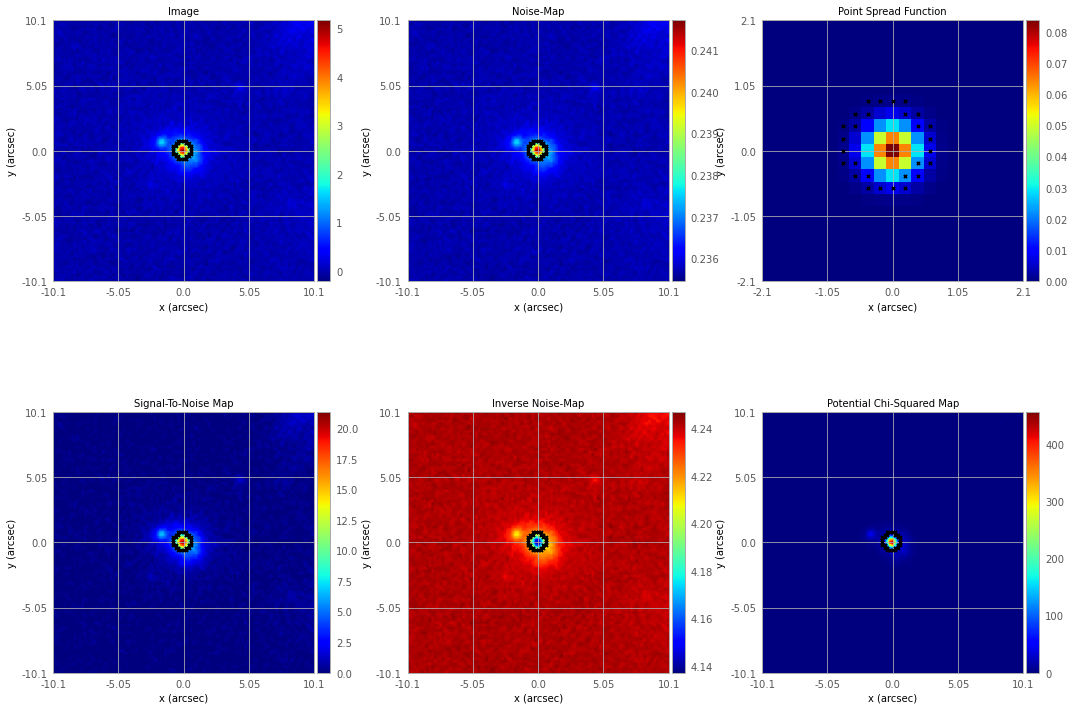

In [7]:
# set experiment number
experiment_number = '2-1'

lens_start.bulge.effective_radius = af.GaussianPrior(mean=1.3435, sigma=0.25, lower_limit=0.0, upper_limit=2.0)
lens_start.bulge.centre_0 = af.UniformPrior(lower_limit=0.0, upper_limit=0.1)
lens_start.bulge.centre_1 = af.UniformPrior(lower_limit=-0.1, upper_limit=0.0)

# set up mask
lens_mask = al.Mask2D.circular(
    shape_native=imaging_r.shape_native, pixel_scales=imaging_r.pixel_scales, sub_size=2, radius=0.8, centre=(0.075, -0.075)
)
visuals_2d = aplt.Visuals2D(mask=lens_mask)

# plot subplots for first view
print('Plotting r-band')
imaging_plotter_r = aplt.ImagingPlotter(
    imaging=imaging_r, visuals_2d=visuals_2d
)
imaging_plotter_r.subplot_imaging()

# set up phase
phase1 = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix=f"{output_folder}", name=f"experiment_{experiment_number}_phase1_{datetime}", n_live_points=60,
        evidence_tolerance=1.0, walks = 10
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens_start)#, source=source)
)

In [8]:
# run the phase
print('Phase running...')
tick = time.perf_counter()
phase1_result = phase1.run(dataset=imaging_r, mask=lens_mask)
tock = time.perf_counter()
print(f'Work complete! Took us {tock-tick} seconds or {(tock-tick)/60} minutes.')

Phase running...


INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.
INFO:root:No Dynesty samples found, beginning new non-linear search. 
199it [00:07, 15.94it/s, bound: 2 | nc: 10 | ncall: 1995 | eff(%):  9.975 | loglstar:   -inf < -480.388 <    inf | logz: -488.296 +/-  0.508 | dlogz: 478.457 >  1.000]   /soft/anaconda3/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
205it [00:08, 17.06it/s, bound: 3 | nc: 10 | ncall: 2055 | eff(%):  9.976 | loglstar:   -inf < -424.847 <    inf | logz: -433.007 +/-  0.525 | dlogz: 425.379 >  1.000]/soft/anaconda3/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
219it

Work complete! Took us 67.10181249305606 seconds or 1.1183635415509343 minutes.


Log likelihood: 19.69676040242102
Model: Galaxy (centre_0, GaussianPrior, mean = 0.0332005804705393, sigma = 0.05), (centre_1, GaussianPrior, mean = -0.061922546222335326, sigma = 0.05), (elliptical_comps_0, GaussianPrior, mean = -0.09224971972403873, sigma = 0.2), (elliptical_comps_1, GaussianPrior, mean = 0.010370509503389037, sigma = 0.2), (intensity, GaussianPrior, mean = 0.3136914702267038, sigma = 0.24664436771105652), (effective_radius, GaussianPrior, mean = 1.4308023942721424, sigma = 1.4308023942721424), (sersic_index, GaussianPrior, mean = 3.8969793816749134, sigma = 1.5), None, None


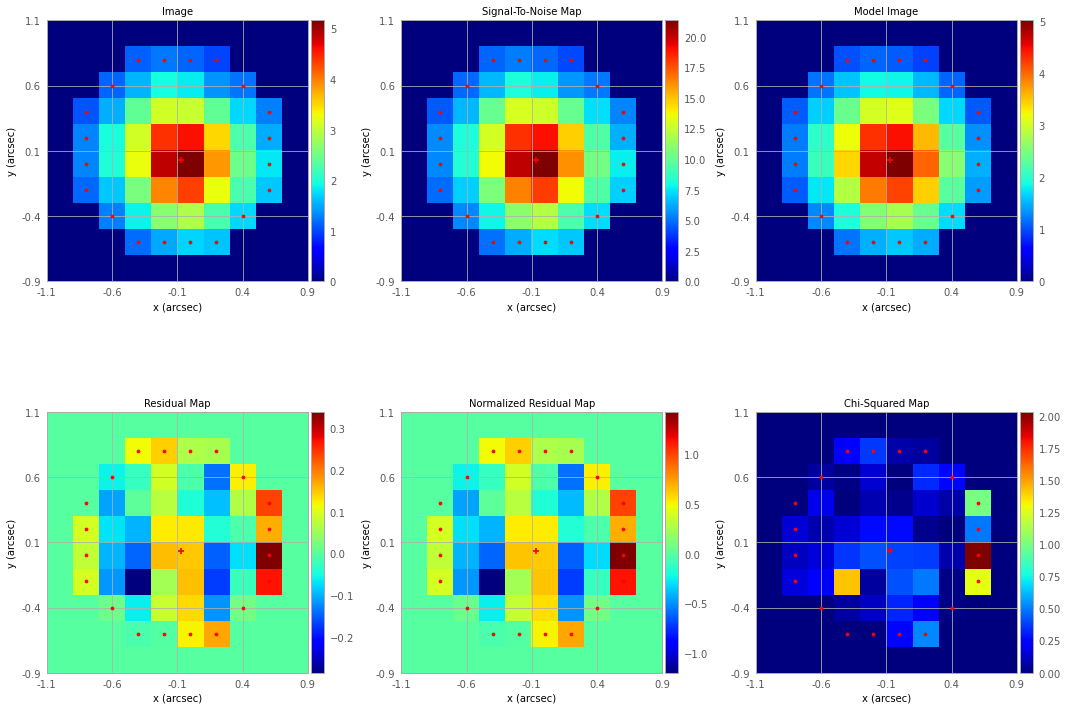

In [9]:
# write the results to the log
print(f'Log likelihood: {phase1_result.log_likelihood}')
print(f'Model: {phase1_result.model}')

phase1_time = tock-tick

# plot it!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase1_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()
# it's still fitting too much of the arc light

### Phase 2: Fit source light

In [10]:
# set up mask
source_mask = al.Mask2D.circular_annular(
    shape_native=imaging_r.shape_native, 
    pixel_scales=imaging_r.pixel_scales, 
    sub_size=2, 
    inner_radius=0.8, 
    outer_radius=2.5,
    centre=(0.075, -0.075)
)
visuals_2d = aplt.Visuals2D(mask=lens_mask)

# set up proxy lens mass (no light)
lens_mass = af.PriorModel(al.mp.EllipticalSersic)
lens_mass.take_attributes(source=phase1_result.instance.galaxies.lens)

# lens galaxy
lens = al.GalaxyModel(redshift=zlens,
                     mass=lens_mass)

# set up source light
source = al.GalaxyModel(
    redshift=zsource, bulge=al.lp.SphericalExponential)

# source position
source.bulge.centre_0 = af.UniformPrior(lower_limit=-3, upper_limit=3)
source.bulge.centre_1 = af.UniformPrior(lower_limit=-3, upper_limit=3)
source.bulge.effective_radius = af.UniformPrior(lower_limit=0.0, upper_limit=5.0)

Plotting r-band


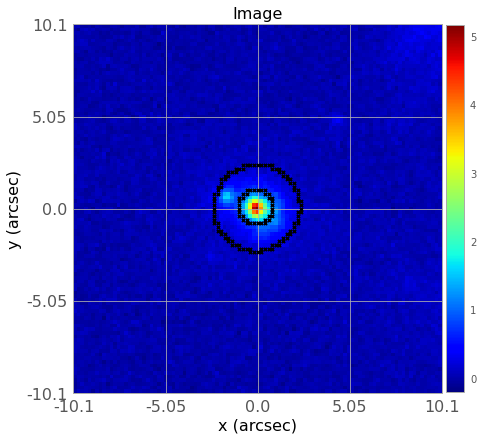

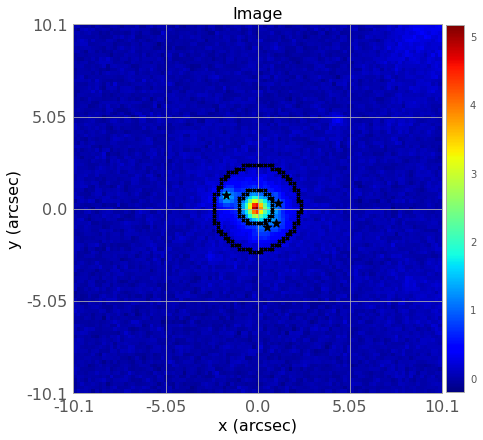

In [11]:
# Set up the positions... (GUI is not working...)

# plot the r-band image to see it
print('Plotting r-band')
imaging_plotter_r = aplt.ImagingPlotter( # this is where the noise is coming up weird
    imaging=imaging_r, visuals_2d=aplt.Visuals2D(mask=source_mask)
)
imaging_plotter_r.figures(image=True)

# set positions
imaging_r.positions = al.Grid2DIrregular(
    [(0.75, -1.75), (-0.8, 1.0), (-1.0, 0.5), (0.3, 1.1)]
)

# plot the image
visuals_2d = aplt.Visuals2D(mask=source_mask, positions=imaging_r.positions)
imaging_plotter_r = aplt.ImagingPlotter(imaging=imaging_r, visuals_2d=visuals_2d)
imaging_plotter_r.figures(image=True)

In [12]:
# set the settings to include the positions
settings_lens = al.SettingsLens(positions_threshold=1.0)

settings = al.SettingsPhaseImaging(
    settings_masked_imaging=settings_masked_imaging, settings_lens=settings_lens
)

In [13]:
# set up phase
phase2 = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix=f'{output_folder}', name=f"experiment_{experiment_number}_phase2_fit_{datetime}", n_live_points=120,
        evidence_tolerance=0.25, walks=10, facc=0.4
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens, source=source)#, source=source)
)

In [14]:
# run phase
# run the phase
print('Phase running...')
tick = time.perf_counter()
phase2_result = phase2.run(dataset=imaging_r, mask=source_mask)
tock = time.perf_counter()
print(f'Work complete! Took us {tock-tick} seconds or {(tock-tick)/60} minutes.')

INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.


Phase running...


INFO:root:No Dynesty samples found, beginning new non-linear search. 
7it [00:08,  1.26s/it, bound: 1 | nc: 10 | ncall: 777 | eff(%):  0.901 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  0.250] /soft/anaconda3/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
181it [00:57,  3.15it/s, +120 | bound: 11 | nc: 1 | ncall: 2625 | eff(%): 11.467 | loglstar:   -inf < -209.350 <    inf | logz: -216.341 +/-  0.684 | dlogz:  1.099 >  0.250]  
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
425it [01:13,  5.78it/s, +120 | bound: 24 | nc: 1 | ncall: 5133 | eff(%): 10.618 | loglstar:   -inf < -154.363 <    inf | logz: -163.373 +/-  0.702 | dlogz:  1.095 >  0.250]
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
66

Work complete! Took us 2389.432170625776 seconds or 39.8238695104296 minutes.


Log likelihood: 178.53911385511924
Model: Galaxy (centre_0, GaussianPrior, mean = -0.03104450732615568, sigma = 0.16321372870642), (centre_1, GaussianPrior, mean = -0.07155385675837407, sigma = 0.14623623073901262), (elliptical_comps_0, GaussianPrior, mean = 0.2873689812071206, sigma = 0.2), (elliptical_comps_1, GaussianPrior, mean = -0.25728832865166046, sigma = 0.2), (intensity, GaussianPrior, mean = 0.006648347256643939, sigma = 8.670088844374924), (effective_radius, GaussianPrior, mean = 8.58256737220306, sigma = 20.792179127654016), (sersic_index, GaussianPrior, mean = 2.089464633168102, sigma = 2.048878719852229), (mass_to_light_ratio, GaussianPrior, mean = 9.511259442609594, sigma = 124744.31179170085), Galaxy (centre_0, GaussianPrior, mean = 0.052432422318838, sigma = 0.07859741435289888), (centre_1, GaussianPrior, mean = -0.2513959722095234, sigma = 0.09938024771249257), (intensity, GaussianPrior, mean = 0.3638542870193988, sigma = 0.1819271435096994), (effective_radius, Gauss

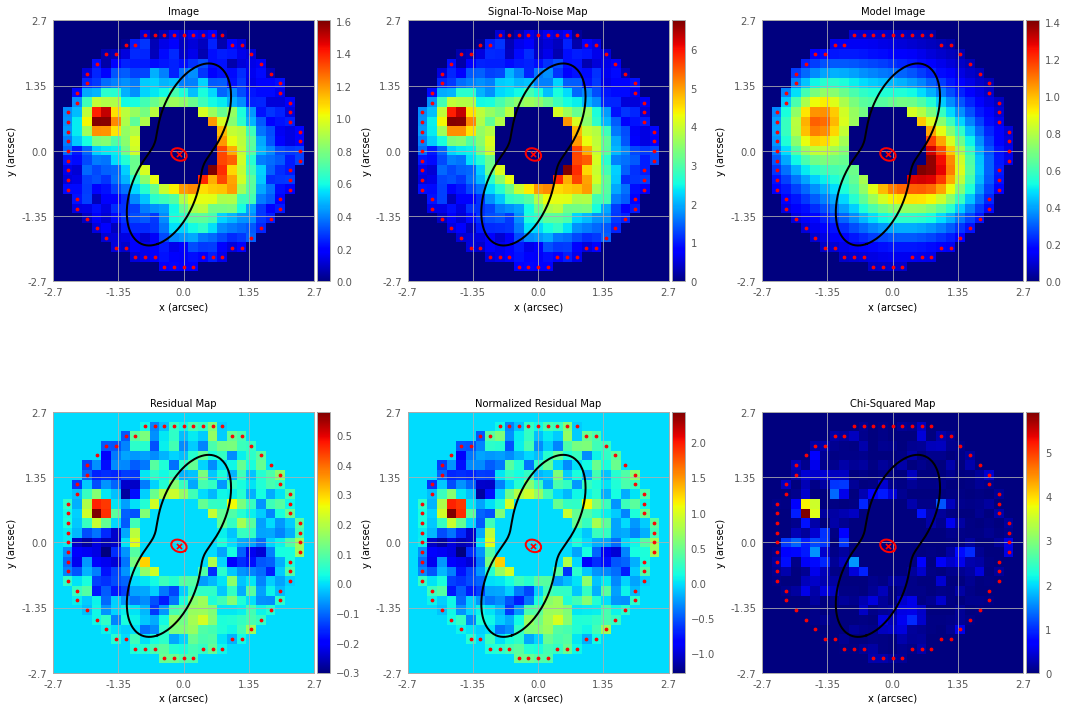

In [15]:
# write the results to the log
print(f'Log likelihood: {phase2_result.log_likelihood}')
print(f'Model: {phase2_result.model}')

phase2_time=tock-tick

# plot it!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase2_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

### Phase 3: Fit all.

In [23]:
#set up lens and source

# set stellar mass/light profile
bulge = af.PriorModel(al.lmp.EllipticalSersic)
bulge.take_attributes(source=phase1_result.instance.galaxies.lens.bulge)

# set dark matter profile
dark = af.PriorModel(al.mp.SphericalNFWMCRLudlow)
dark.mass_at_200 = af.LogUniformPrior(lower_limit=1e8, upper_limit=1e15)
dark.redshift_object = zlens
dark.redshift_source = zsource

# make dark matter centered at stellar mass center

lens = al.GalaxyModel(
    redshift=zlens, bulge=bulge, dark=dark
)

lens.bulge.centre = lens.dark.centre

# set source light profile
source_bulge = af.PriorModel(al.lp.SphericalExponential)
source_bulge.take_attributes(source=phase2_result.instance.galaxies.source.bulge)

source = al.GalaxyModel(
    redshift=zsource, bulge=source_bulge)

# set up mask
mask = al.Mask2D.circular(
    shape_native=imaging_r.shape_native, pixel_scales=imaging_r.pixel_scales, sub_size=2, radius=3.0
)
visuals_2d = aplt.Visuals2D(mask=mask)


In [26]:
datetime = time.strftime("%d%m%Y-%H%M%S")
# set up phase
phase3 = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix=f'{output_folder}', name=f"experiment_{experiment_number}_phase3_fit_{datetime}", n_live_points=150,
        evidence_tolerance=0.25, walks=10, facc=0.4
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens, source=source)#, source=source)
)

In [ ]:
# run phase
# run the phase
print('Phase running...')
tick = time.perf_counter()
phase3_result = phase3.run(dataset=imaging_r, mask=mask)
tock = time.perf_counter()
print(f'Work complete! Took us {tock-tick} seconds or {(tock-tick)/60} minutes.')

In [21]:
# write the results to the log
print(f'Log likelihood: {phase3_result.log_likelihood}')
print(f'Model: {phase3_result.model}')

phase3_time=tock-tick

log = open(f"{output_folder}experiment_log", 'a') # append the log
lines = [f'Experiment {experiment_number} \n',
         f'Phase 1 \n',
         f'Time to convergence: {phase1_time} seconds \n', 
         f'Log likelihood: {phase1_result.log_likelihood} \n',
         f'Model: {str(phase1_result.model)} \n',
         f'Phase 2 \n',
         f'Time to convergence: {phase2_time} seconds \n', 
         f'Log likelihood: {phase2_result.log_likelihood} \n', 
         f'Model: {str(phase2_result.model)} \n', '\n' # set lines to write the model result
         f'Phase 3 \n',
         f'Time to convergence: {phase3_time} seconds \n', 
         f'Log likelihood: {phase3_result.log_likelihood} \n', 
        f'Model: {str(phase3_result.model)} \n', '\n'] # set lines to write the model result
log.writelines(lines) # write lines
log.close()

Log likelihood: -52.72219551978793
Model: Galaxy (centre_0, GaussianPrior, mean = -0.005293825505944353, sigma = 0.05), (centre_1, GaussianPrior, mean = 0.01758584814509639, sigma = 0.05), (mass_to_light_ratio, GaussianPrior, mean = 0.7724228573344197, sigma = 0.2317268572003259), (centre_0, GaussianPrior, mean = -0.005293825505944353, sigma = 0.05), (centre_1, GaussianPrior, mean = 0.01758584814509639, sigma = 0.05), (mass_at_200, GaussianPrior, mean = 1125573138.8684447, sigma = 37290153590.088295), Galaxy , None, None


In [ ]:
# append performance log
data_list = [[experiment_number, 
            phase1_time,
            phase1_result.log_likelihood,
            phase2_time, 
            phase2_result.log_likelihood,
            phase3_time, 
            phase3_result.log_likelihood
             ]]
new_dataframe_entry = pd.DataFrame(data_list,
                                  columns=['Experiment', 
                                           'phase1_time', 
                                           'phase1_likelihood', 
                                           'phase2_time', 
                                           'phase2_likelihood', 
                                           'phase3_time',
                                           'phase3_likelihood'
                                           ])
performance_log = pd.concat([performance_log, new_dataframe_entry])
print(performance_log)
performance_log.to_csv(f'{csv_path}G{gama_id}_{links_id}_performance_log.csv')
#print(phase_result.model)
# get samples to see how it ran?
#log_likelihoods = phase_result.samples.log_likelihoods
#x = np.arange(0, len(log_likelihoods), 1)
#plt.plot(x[500:], log_likelihoods[500:])
#plt.xlim()

# plot it!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase3_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

## Experiment 2-2

Phase 1: lens mask 0.8, nlive=60, tolerance=1.0, walks=10

Phase 2: source mask (1.0, 3.0), nlive=120, tolerance=0.25, walks=10, facc=0.4, 4 positions at threshold=1.0

Phase 3: mask 3.0, nlive=150, tolerance=0.25, walks=10, facc=0.4

### Phase 1: Fit lens light.

Plotting r-band


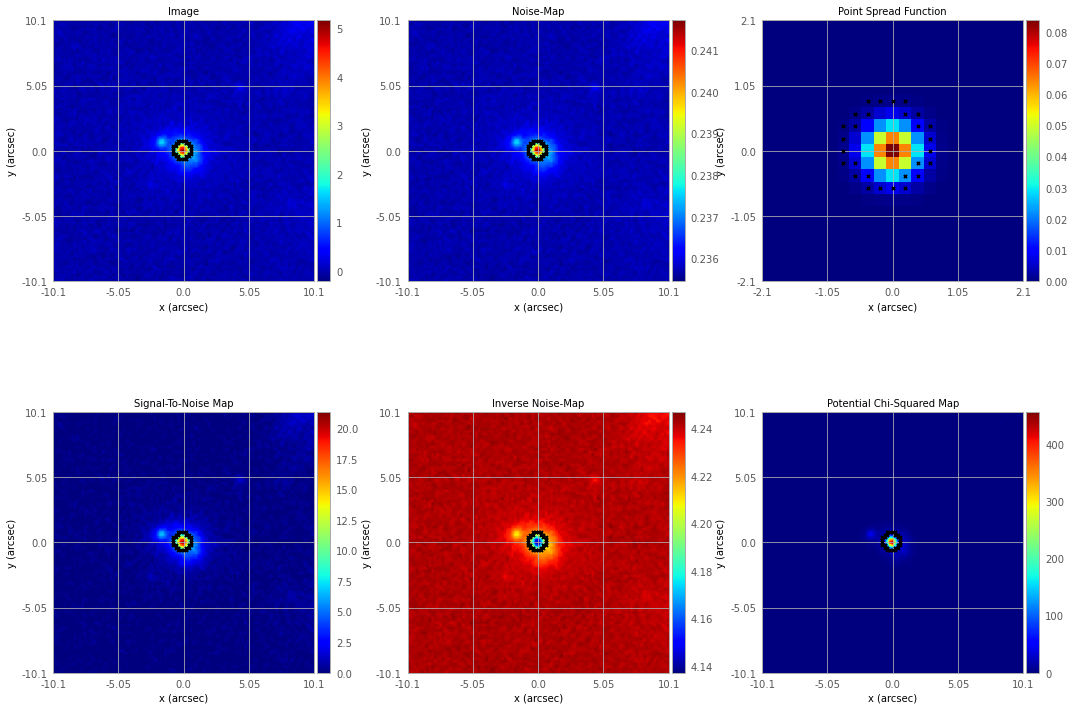

In [29]:
# set experiment number
experiment_number = '2-2'

lens_start.bulge.effective_radius = af.GaussianPrior(mean=1.3435, sigma=0.25, lower_limit=0.0, upper_limit=2.0)
lens_start.bulge.centre_0 = af.UniformPrior(lower_limit=0.0, upper_limit=0.1)
lens_start.bulge.centre_1 = af.UniformPrior(lower_limit=-0.1, upper_limit=0.0)

# set up mask
lens_mask = al.Mask2D.circular(
    shape_native=imaging_r.shape_native, pixel_scales=imaging_r.pixel_scales, sub_size=2, radius=0.8, centre=(0.075, -0.075)
)
visuals_2d = aplt.Visuals2D(mask=lens_mask)

# plot subplots for first view
print('Plotting r-band')
imaging_plotter_r = aplt.ImagingPlotter(
    imaging=imaging_r, visuals_2d=visuals_2d
)
imaging_plotter_r.subplot_imaging()

# set up phase
phase1 = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix=f"{output_folder}", name=f"experiment_{experiment_number}_phase1_{datetime}", n_live_points=60,
        evidence_tolerance=1.0, walks = 10
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens_start)#, source=source)
)

In [30]:
# run the phase
print('Phase running...')
tick = time.perf_counter()
phase1_result = phase1.run(dataset=imaging_r, mask=lens_mask)
tock = time.perf_counter()
print(f'Work complete! Took us {tock-tick} seconds or {(tock-tick)/60} minutes.')

INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.


Phase running...


INFO:root:No Dynesty samples found, beginning new non-linear search. 
256it [00:10, 25.59it/s, +60 | bound: 2 | nc: 1 | ncall: 2562 | eff(%): 12.334 | loglstar:   -inf <  0.127 <    inf | logz: -8.908 +/-  0.743 | dlogz:  1.099 >  1.000]   
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
477it [00:10, 44.82it/s, +60 | bound: 29 | nc: 1 | ncall: 5064 | eff(%): 10.604 | loglstar:   -inf < 13.628 <    inf | logz:  2.260 +/-  0.726 | dlogz:  0.428 >  1.000] 
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
689it [00:10, 68.44it/s, +60 | bound: 56 | nc: 1 | ncall: 7569 | eff(%):  9.896 | loglstar:   -inf < 18.531 <    inf | logz:  4.701 +/-  0.944 | dlogz:  0.173 >  1.000]
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).
901it [00:09, 93.44it/s, +60 | bound: 82 | nc: 1 | ncall: 9967 | eff(%):  9.642 | loglstar:   -inf < 20.014 <    inf | logz:  5.057 +/-  0.701 | dlogz:  0.0

Work complete! Took us 63.71485610306263 seconds or 1.0619142683843772 minutes.


Log likelihood: 20.01398894076373
Model: Galaxy (centre_0, GaussianPrior, mean = 0.03394003883579427, sigma = 0.05), (centre_1, GaussianPrior, mean = -0.06480091311200434, sigma = 0.05), (elliptical_comps_0, GaussianPrior, mean = -0.09661672891319106, sigma = 0.2), (elliptical_comps_1, GaussianPrior, mean = -0.0023266479570027278, sigma = 0.2), (intensity, GaussianPrior, mean = 0.3091300460596771, sigma = 0.27321739785265897), (effective_radius, GaussianPrior, mean = 1.4597872049854619, sigma = 1.4597872049854619), (sersic_index, GaussianPrior, mean = 3.9699801713940612, sigma = 1.5), None, None


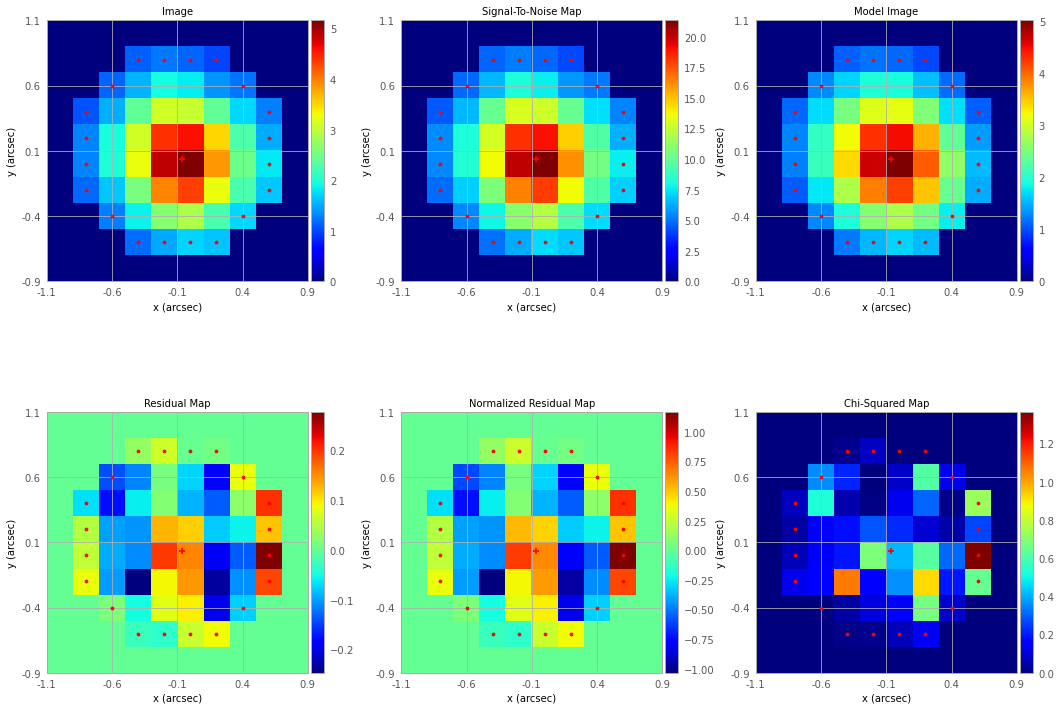

In [31]:
# write the results to the log
print(f'Log likelihood: {phase1_result.log_likelihood}')
print(f'Model: {phase1_result.model}')

phase1_time = tock-tick

# plot it!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase1_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()
# it's still fitting too much of the arc light

### Phase 2: Fit source light

In [42]:
# set up mask
source_mask = al.Mask2D.circular_annular(
    shape_native=imaging_r.shape_native, 
    pixel_scales=imaging_r.pixel_scales, 
    sub_size=2, 
    inner_radius=0.9, 
    outer_radius=2.6,
    centre=(0.075, -0.075)
)
visuals_2d = aplt.Visuals2D(mask=lens_mask)

# set up proxy lens mass (no light)
lens_mass = af.PriorModel(al.mp.EllipticalSersic)
lens_mass.take_attributes(source=phase1_result.instance.galaxies.lens)

# lens galaxy
lens = al.GalaxyModel(redshift=zlens,
                     mass=lens_mass)

# set up source light
source = al.GalaxyModel(
    redshift=zsource, bulge=al.lp.SphericalExponential)

# source position
source.bulge.centre_0 = af.UniformPrior(lower_limit=-3, upper_limit=3)
source.bulge.centre_1 = af.UniformPrior(lower_limit=-3, upper_limit=3)
source.bulge.effective_radius = af.UniformPrior(lower_limit=0.0, upper_limit=5.0)

Plotting r-band


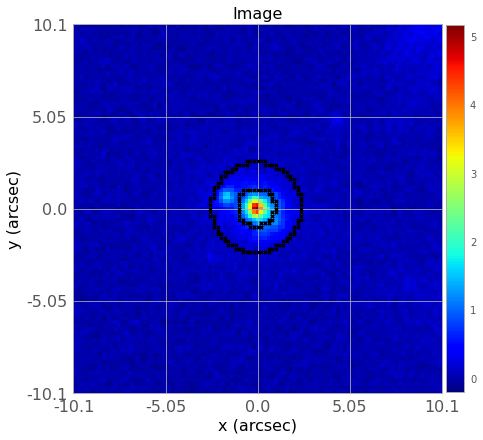

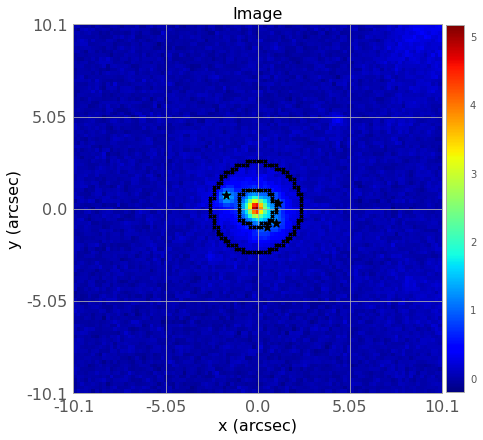

In [44]:
# Set up the positions... (GUI is not working...)

# plot the r-band image to see it
print('Plotting r-band')
imaging_plotter_r = aplt.ImagingPlotter( # this is where the noise is coming up weird
    imaging=imaging_r, visuals_2d=aplt.Visuals2D(mask=source_mask)
)
imaging_plotter_r.figures(image=True)

# set positions
imaging_r.positions = al.Grid2DIrregular(
    [(0.75, -1.75), (-0.8, 1.0), (-1.0, 0.5), (0.3, 1.1)]
)

# plot the image
visuals_2d = aplt.Visuals2D(mask=source_mask, positions=imaging_r.positions)
imaging_plotter_r = aplt.ImagingPlotter(imaging=imaging_r, visuals_2d=visuals_2d)
imaging_plotter_r.figures(image=True)

In [45]:
# set the settings to include the positions
settings_lens = al.SettingsLens(positions_threshold=1.0)

settings = al.SettingsPhaseImaging(
    settings_masked_imaging=settings_masked_imaging, settings_lens=settings_lens
)

In [46]:
# set up phase
phase2 = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix=f'{output_folder}', name=f"experiment_{experiment_number}_phase2_fit_{datetime}", n_live_points=120,
        evidence_tolerance=0.25, walks=10, facc=0.4
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens, source=source)#, source=source)
)

In [47]:
# run phase
# run the phase
print('Phase running...')
tick = time.perf_counter()
phase2_result = phase2.run(dataset=imaging_r, mask=source_mask)
tock = time.perf_counter()
print(f'Work complete! Took us {tock-tick} seconds or {(tock-tick)/60} minutes.')

INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.


Phase running...


INFO:root:No Dynesty samples found, beginning new non-linear search. 
218it [01:05,  3.31it/s, +120 | bound: 13 | nc: 1 | ncall: 2627 | eff(%): 12.866 | loglstar:   -inf < -116.892 <    inf | logz: -124.190 +/-  0.437 | dlogz:  1.099 >  0.250] 
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
456it [01:13,  6.16it/s, +120 | bound: 27 | nc: 1 | ncall: 5132 | eff(%): 11.224 | loglstar:   -inf < -46.722 <    inf | logz: -55.990 +/-  0.765 | dlogz:  1.095 >  0.250]
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
684it [01:23,  8.17it/s, +120 | bound: 40 | nc: 1 | ncall: 7637 | eff(%): 10.528 | loglstar:   -inf < 62.658 <    inf | logz: 51.493 +/-  0.803 | dlogz:  1.099 >  0.250] 
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).
919it [01:23, 10.96it/s, +120 | bound: 54 | nc: 1 | ncall: 10186 | eff(%): 10.200 | loglstar:   -inf < 81.589 <    inf | logz: 68.474 +/-  0.771 | d

Work complete! Took us 2209.709153395146 seconds or 36.8284858899191 minutes.


Log likelihood: 198.10784855034896
Model: Galaxy (centre_0, GaussianPrior, mean = -0.05741456731285472, sigma = 0.1924181341236631), (centre_1, GaussianPrior, mean = -0.049705968250515965, sigma = 0.15257083219127454), (elliptical_comps_0, GaussianPrior, mean = 0.2819644920417238, sigma = 0.2), (elliptical_comps_1, GaussianPrior, mean = -0.2542410964178709, sigma = 0.2), (intensity, GaussianPrior, mean = 0.003061997386849837, sigma = 8.950662030015133), (effective_radius, GaussianPrior, mean = 6.613956802913681, sigma = 21.498771980048527), (sersic_index, GaussianPrior, mean = 1.86681141252715, sigma = 2.007189827466409), (mass_to_light_ratio, GaussianPrior, mean = 27.81216177726843, sigma = 182788.77618034818), Galaxy (centre_0, GaussianPrior, mean = 0.03948924582662864, sigma = 0.10027721328206729), (centre_1, GaussianPrior, mean = -0.23937083023721345, sigma = 0.11059444350875774), (intensity, GaussianPrior, mean = 0.35640788206630175, sigma = 0.17820394103315088), (effective_radius

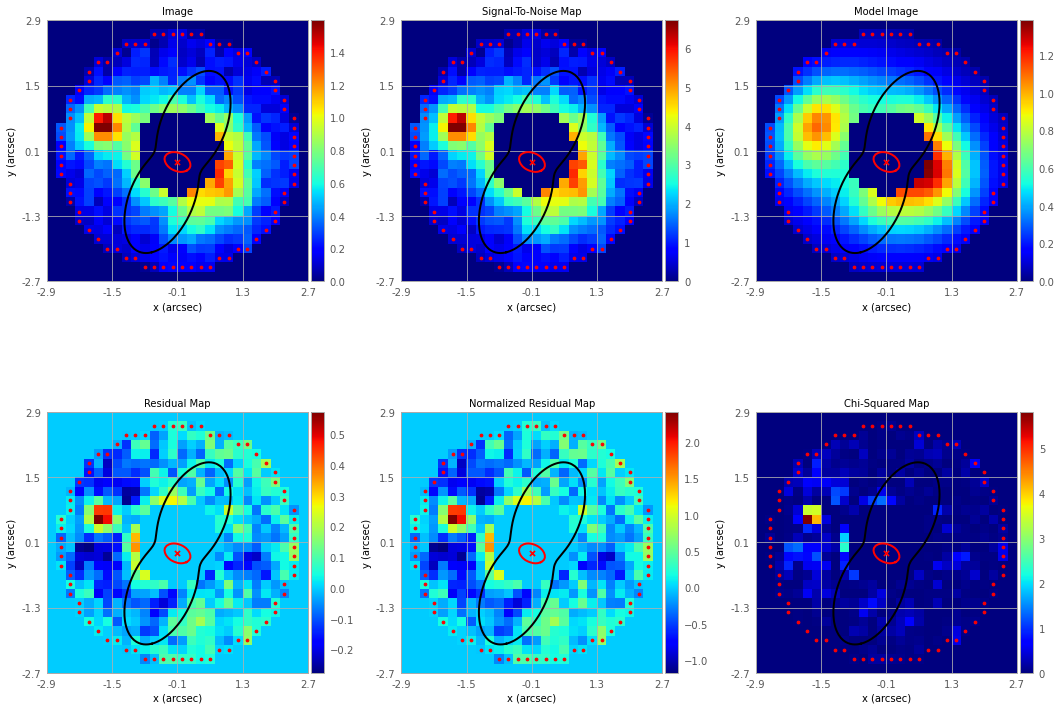

In [48]:
# write the results to the log
print(f'Log likelihood: {phase2_result.log_likelihood}')
print(f'Model: {phase2_result.model}')

phase2_time=tock-tick

# plot it!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase2_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

### Phase 3: Fit all.

In [49]:
#set up lens and source

# set stellar mass/light profile
bulge = af.PriorModel(al.lmp.EllipticalSersic)
bulge.take_attributes(source=phase1_result.instance.galaxies.lens.bulge)

# set dark matter profile
dark = af.PriorModel(al.mp.SphericalNFWMCRLudlow)
dark.mass_at_200 = af.LogUniformPrior(lower_limit=1e8, upper_limit=1e15)
dark.redshift_object = zlens
dark.redshift_source = zsource

# make dark matter centered at stellar mass center

lens = al.GalaxyModel(
    redshift=zlens, bulge=bulge, dark=dark
)

lens.bulge.centre = lens.dark.centre

# set source light profile
source_bulge = af.PriorModel(al.lp.SphericalExponential)
source_bulge.take_attributes(source=phase2_result.instance.galaxies.source.bulge)

source = al.GalaxyModel(
    redshift=zsource, bulge=source_bulge)

# set up mask
mask = al.Mask2D.circular(
    shape_native=imaging_r.shape_native, pixel_scales=imaging_r.pixel_scales, sub_size=2, radius=3.0
)
visuals_2d = aplt.Visuals2D(mask=mask)


In [50]:
datetime = time.strftime("%d%m%Y-%H%M%S")
# set up phase
phase3 = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix=f'{output_folder}', name=f"experiment_{experiment_number}_phase3_fit_{datetime}", n_live_points=150,
        evidence_tolerance=0.25, walks=10, facc=0.4
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens, source=source)#, source=source)
)

In [51]:
# run phase
# run the phase
print('Phase running...')
tick = time.perf_counter()
phase3_result = phase3.run(dataset=imaging_r, mask=mask)
tock = time.perf_counter()
print(f'Work complete! Took us {tock-tick} seconds or {(tock-tick)/60} minutes.')

INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.


Phase running...


INFO:root:No Dynesty samples found, beginning new non-linear search. 
215it [01:26,  2.50it/s, +150 | bound: 11 | nc: 1 | ncall: 2653 | eff(%): 13.758 | loglstar:   -inf < -138.871 <    inf | logz: -145.923 +/-  0.435 | dlogz:  1.042 >  0.250]
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
461it [01:49,  4.21it/s, +150 | bound: 21 | nc: 1 | ncall: 5157 | eff(%): 11.848 | loglstar:   -inf < -138.871 <    inf | logz: -147.160 +/-  0.640 | dlogz:  0.803 >  0.250]
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
708it [02:08,  5.52it/s, +150 | bound: 32 | nc: 1 | ncall: 7668 | eff(%): 11.189 | loglstar:   -inf < -138.871 <    inf | logz: -147.549 +/-  0.562 | dlogz:  0.302 >  0.250]
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).
958it [02:48,  5.67it/s, +150 | bound: 43 | nc: 1 | ncall: 10169 | eff(%): 10.896 | loglstar:   -inf < -138.166 <    inf | logz: -147.391 +/-  0

Work complete! Took us 1022.3099887929857 seconds or 17.03849981321643 minutes.


In [52]:
# write the results to the log
print(f'Log likelihood: {phase3_result.log_likelihood}')
print(f'Model: {phase3_result.model}')

phase3_time=tock-tick

log = open(f"{output_folder}experiment_log", 'a') # append the log
lines = [f'Experiment {experiment_number} \n',
         f'Phase 1 \n',
         f'Time to convergence: {phase1_time} seconds \n', 
         f'Log likelihood: {phase1_result.log_likelihood} \n',
         f'Model: {str(phase1_result.model)} \n',
         f'Phase 2 \n',
         f'Time to convergence: {phase2_time} seconds \n', 
         f'Log likelihood: {phase2_result.log_likelihood} \n', 
         f'Model: {str(phase2_result.model)} \n', '\n' # set lines to write the model result
         f'Phase 3 \n',
         f'Time to convergence: {phase3_time} seconds \n', 
         f'Log likelihood: {phase3_result.log_likelihood} \n', 
        f'Model: {str(phase3_result.model)} \n', '\n'] # set lines to write the model result
log.writelines(lines) # write lines
log.close()

Log likelihood: -137.83188200099994
Model: Galaxy (centre_0, GaussianPrior, mean = -0.004752618473617859, sigma = 0.05), (centre_1, GaussianPrior, mean = 0.02186559062975917, sigma = 0.05), (mass_to_light_ratio, GaussianPrior, mean = 0.7209829649990175, sigma = 0.21629488949970524), (centre_0, GaussianPrior, mean = -0.004752618473617859, sigma = 0.05), (centre_1, GaussianPrior, mean = 0.02186559062975917, sigma = 0.05), (mass_at_200, GaussianPrior, mean = 1139538034.7422001, sigma = 34064618492.27396), Galaxy , None, None


    Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1.1  \
0          0.0           0.0             0.0               0.0   
1          1.0           1.0             0.0               NaN   
2          2.0           2.0             0.0               NaN   
3          3.0           3.0             0.0               NaN   
4          4.0           4.0             0.0               NaN   
5          5.0           5.0             0.0               NaN   
6          6.0           0.0             NaN               NaN   
7          7.0           0.0             NaN               NaN   
8          8.0           0.0             NaN               NaN   
9          9.0           0.0             NaN               NaN   
10        10.0           0.0             NaN               NaN   
11        11.0           0.0             NaN               NaN   
12        12.0           0.0             NaN               NaN   
13        13.0           0.0             NaN               NaN   
14        

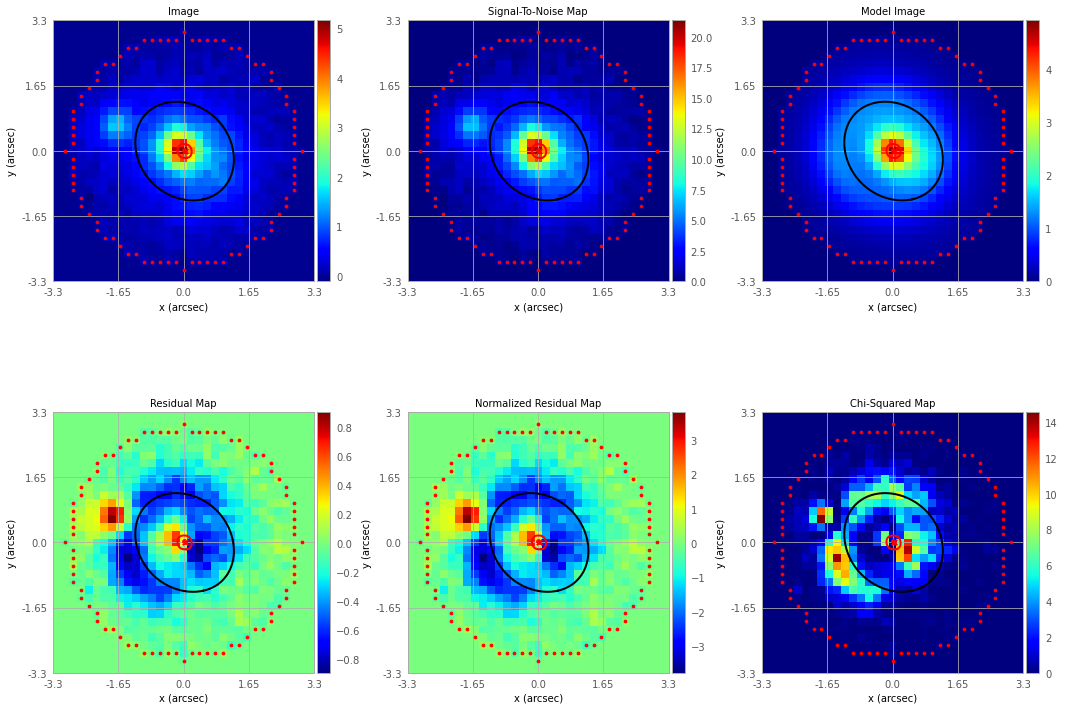

In [53]:
# append performance log
data_list = [[experiment_number, 
            phase1_time,
            phase1_result.log_likelihood,
            phase2_time, 
            phase2_result.log_likelihood,
            phase3_time, 
            phase3_result.log_likelihood
             ]]
new_dataframe_entry = pd.DataFrame(data_list,
                                  columns=['Experiment', 
                                           'phase1_time', 
                                           'phase1_likelihood', 
                                           'phase2_time', 
                                           'phase2_likelihood', 
                                           'phase3_time',
                                           'phase3_likelihood'
                                           ])
performance_log = pd.concat([performance_log, new_dataframe_entry])
print(performance_log)
performance_log.to_csv(f'{csv_path}G{gama_id}_{links_id}_performance_log.csv')
#print(phase_result.model)
# get samples to see how it ran?
#log_likelihoods = phase_result.samples.log_likelihoods
#x = np.arange(0, len(log_likelihoods), 1)
#plt.plot(x[500:], log_likelihoods[500:])
#plt.xlim()

# plot it!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase3_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()